# Differnet Paramterization

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

In [ ]:
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

In [6]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [ ]:
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

In [ ]:
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

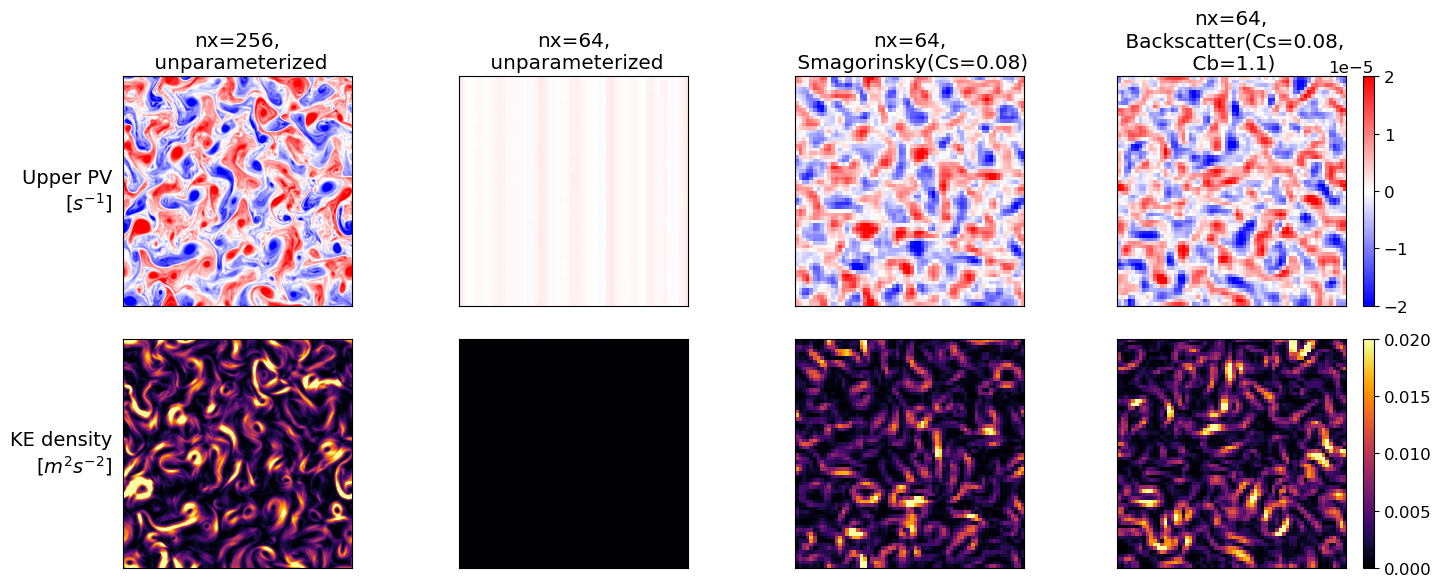

In [17]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

vlim = 2e-2
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()

In [18]:
sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res))
    for sim in sims])

DiagnosticNotFilledError: Diagnostic Ensspec has not been filled. Please adjust tavestart and taveint.

In [ ]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-2,2e2)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-8,2e-6)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()

In [19]:
def plot_spectra(m):
    m_ds = m.to_dataset().isel(time=-1)
    diag_names_enstrophy = ['ENSflux', 'ENSgenspec', 'ENSfrictionspec', 'ENSDissspec', 'ENSparamspec']
    diag_names_energy = ['APEflux', 'APEgenspec', 'KEflux', 'KEfrictionspec', 'Dissspec', 'paramspec']

    bud_labels_list = [['APE gen','APE flux','KE flux','Bottom drag','Diss.','Param.'],
                       ['ENS gen','ENS flux','Dissipation','Friction','Param.']]
    title_list = ['Spectral Energy Transfer', 'Spectral Enstrophy Transfer']
    plt.figure(figsize = [15, 5])
    for p, diag_names in enumerate([diag_names_energy, diag_names_enstrophy]):
        bud = []
        for name in diag_names:
            kr, spec = pyqg.diagnostic_tools.calc_ispec(m, getattr(m_ds, name).data.squeeze())
            bud.append(spec.copy())
        plt.subplot(1, 2, p+1)
        [plt.semilogx(kr, term, label=label) for term, label in zip(bud, bud_labels_list[p])]
        plt.semilogx(kr, -np.vstack(bud).sum(axis=0), 'k--', label = 'Resid.')
        plt.legend(loc='best')
        plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
        plt.title(title_list[p])
    plt.tight_layout()

AttributeError: 'Dataset' object has no attribute 'ENSparamspec'

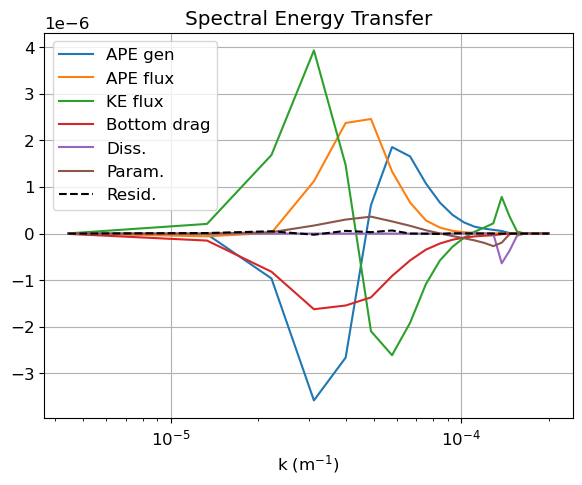

In [20]:
plot_spectra(backscatter)
